In [10]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import torch.nn as nn
import torchaudio
import scipy
import torch
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import tqdm
from scipy import signal

from ipywidgets import interactive
from IPython.display import Audio, display

## CinC2020 Dataset

In [12]:
from datasets import CinC2020

In [13]:
ds = CinC2020(set_seq_len=5000, fs=500, clean_signal=True)
p_signal, sampling_rate, age, sex, dx = ds[0]
p_signal, sampling_rate, age, sex, dx

(array([[ 0.00023028,  0.0015427 ,  0.00132405, ...,  0.01512091,
         -0.00923978, -0.00637499],
        [ 0.000211  ,  0.00056434,  0.00040496, ...,  0.02023743,
         -0.00940781, -0.0072829 ],
        [ 0.00019173, -0.00042402, -0.00053412, ...,  0.02484411,
         -0.00953574, -0.00814077],
        ...,
        [-0.01050244, -0.01771826, -0.00795653, ..., -0.0322378 ,
         -0.0084096 ,  0.00053057],
        [-0.00995213, -0.01562813, -0.00627436, ..., -0.02894913,
         -0.00722838,  0.00120927],
        [-0.00947202, -0.01347868, -0.00444271, ..., -0.02532123,
         -0.00600689,  0.00196797]], dtype=float32),
 500,
 array(53.),
 array(0.),
 164867002)

In [14]:
# display(Audio(data=p_signal[:,0], rate=sampling_rate))
iter_ds = iter(ds)

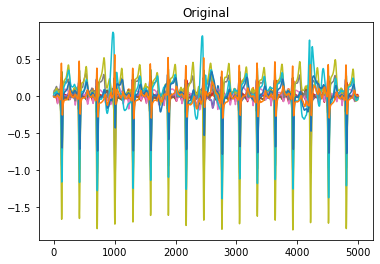

In [15]:
p_signal, sampling_rate, age, sex, dx = next(iter_ds)
# while np.max(p_signal) < 10:
#     p_signal, sampling_rate, age, sex, dx = next(iter_ds)

plt.figure()
plt.title(f"Original")
plt.plot(p_signal)
plt.show()

specgram.shape torch.Size([12, 26, 201])


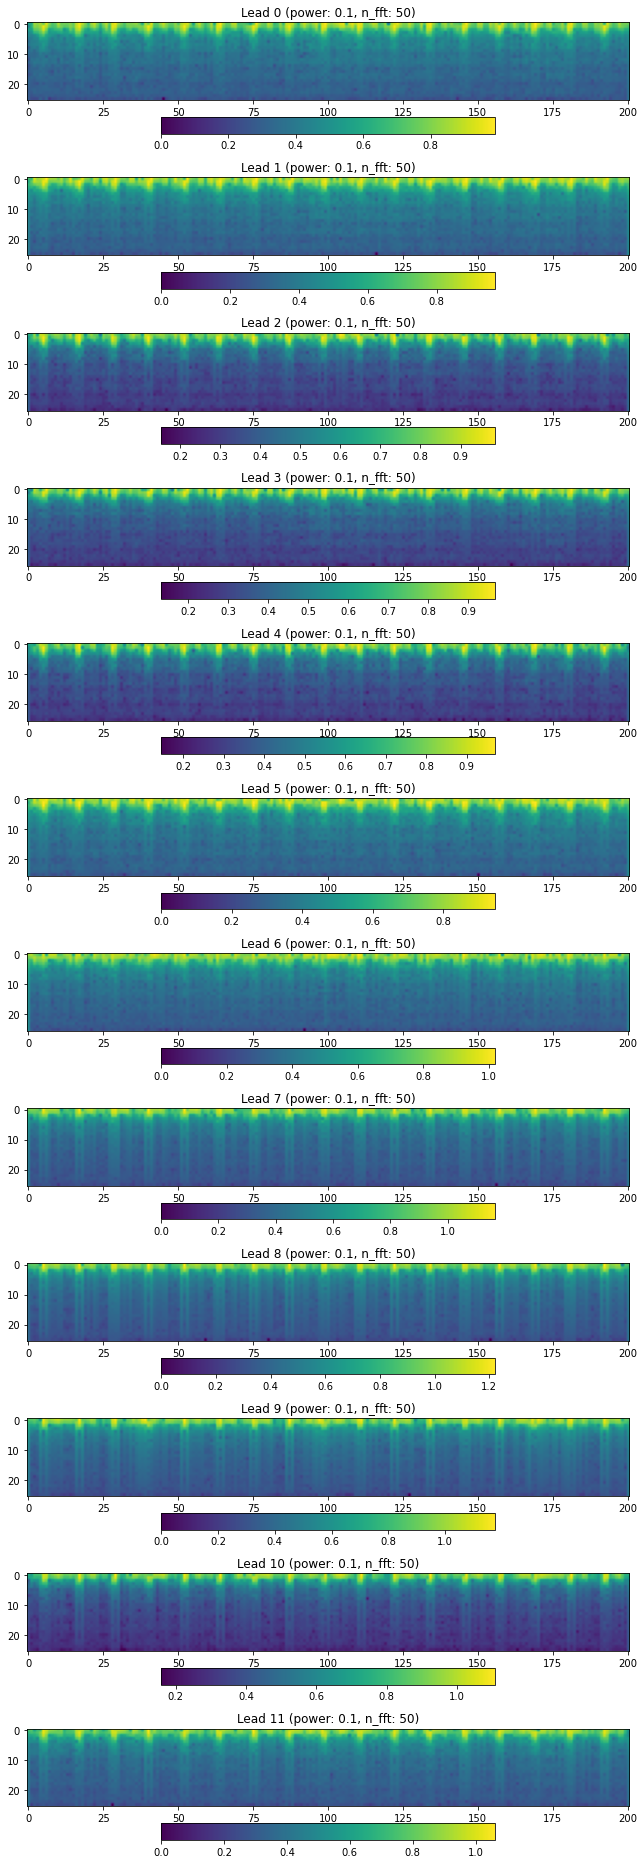

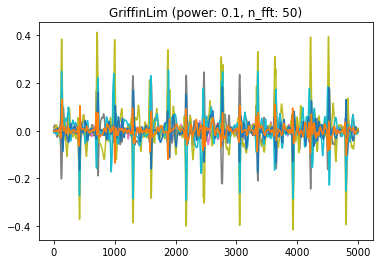

In [16]:
n_fft = 50

# power
power = 0.1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n = torchaudio.transforms.Spectrogram(
        n_fft = n_fft,
        power = power,
        normalized=True
    )
    specgram = n(torch.Tensor(p_signal.T))
    print("specgram.shape", specgram.shape)
    rn = torchaudio.transforms.GriffinLim(n_fft = n_fft, power = power)
    recon = rn(specgram)


fig, axs = plt.subplots(12, 1, figsize=(10, 26))
# plt.imshow(specgram[0,:,:].log2().numpy())
for i in range(12):
    axs[i].set_title(f"Lead {i} (power: {power}, n_fft: {n_fft})")
    pcm = axs[i].imshow(specgram[i,:,:].numpy())
    fig.colorbar(pcm, orientation="horizontal", ax=axs[i])
#     axs[i].colorbar()
fig.tight_layout()
plt.show()

plt.figure()
plt.title(f"GriffinLim (power: {power}, n_fft: {n_fft})")
plt.plot(recon.T)
plt.show()

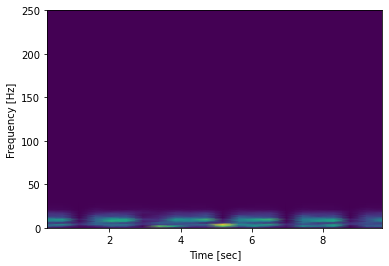

In [17]:
f, t, Sxx =signal.spectrogram(p_signal[:, 0], fs=sampling_rate)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

## Debugging NN Architecture

In [18]:
p_signal, sampling_rate, age, sex, dx = next(iter(DataLoader(ds, batch_size=3)))

p_signal.shape, sampling_rate, age, sex, dx

(torch.Size([3, 5000, 12]),
 tensor([500, 500, 500]),
 tensor([53., 70., 70.], dtype=torch.float64),
 tensor([0., 1., 1.], dtype=torch.float64),
 tensor([164867002, 164861001, 164861001]))

In [19]:
class View(nn.Module):
    def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [20]:
x = torch.transpose(p_signal, 1, 2)
n_fft = 50
power = 0.1

enc = nn.Sequential(
    # torch.Size([b, 12, 26, 201])
    nn.Conv2d(12, 12, (26, 5)),
    nn.Softplus()
)

print("encoder params", sum(dict((p.data_ptr(), p.numel()) for p in enc.parameters()).values()))

dec = nn.Sequential(
    nn.ConvTranspose2d(12, 12, (26, 5)),
    nn.Sigmoid()
)
# 12 * 26 * 201 = 62712
print("decoder params", sum(dict((p.data_ptr(), p.numel()) for p in dec.parameters()).values()))

# encoding forward
print("before spectrogram shape:", x.shape)
samp_in = torchaudio.transforms.Spectrogram(n_fft=n_fft, power=power, normalized=True)(x)
print("before encoder tensor shape:", samp_in.shape)
z = enc(samp_in)
print("bottleneck tensor shape:", z.shape)
samp_out = dec(z)
print("after decoding tensor shape:", samp_out.shape)
samp_out = samp_out.view(-1, 12, 26, 201)
print("after unflatten tensor shape:", samp_out.shape)
assert samp_out.shape == samp_in.shape, f"{samp_out.shape} != {samp_in.shape}"


encoder params 18732
decoder params 18732
before spectrogram shape: torch.Size([3, 12, 5000])
before encoder tensor shape: torch.Size([3, 12, 26, 201])
bottleneck tensor shape: torch.Size([3, 12, 1, 197])
after decoding tensor shape: torch.Size([3, 12, 26, 201])
after unflatten tensor shape: torch.Size([3, 12, 26, 201])


torch.Size([3, 12, 26, 201]) tensor(1.2210) tensor(0.)


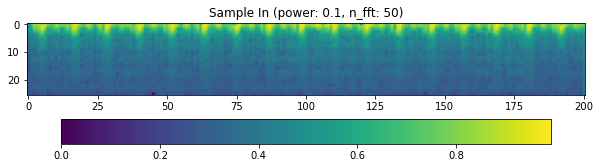

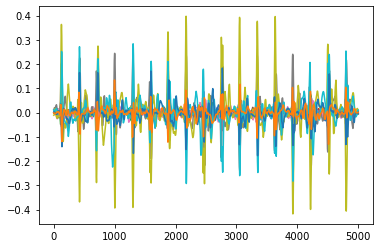

torch.Size([3, 12, 26, 201]) tensor(0.5816, grad_fn=<MaxBackward1>) tensor(0.)


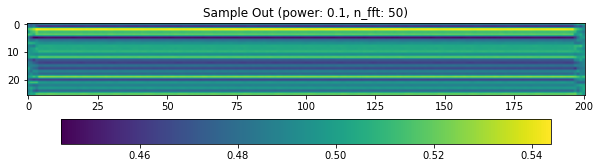

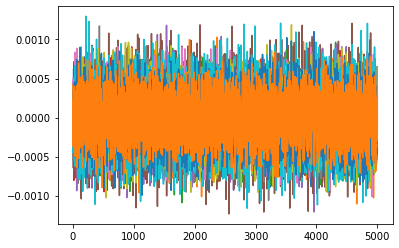

In [21]:
print(samp_in.shape, torch.max(samp_in), torch.min(samp_in))
plt.figure(figsize=(10, 3))

plt.title(f"Sample In (power: {power}, n_fft: {n_fft})")
plt.imshow(samp_in[0, 0, :,:].numpy())
plt.colorbar(orientation="horizontal")
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    recon = torchaudio.transforms.GriffinLim(n_fft=n_fft, power=power, normalized=True)(samp_in)

plt.figure()
plt.plot(recon[0, :, :].T)
plt.show()

samp_out = dec(enc(samp_in))
samp_out = samp_out.view(-1, 12, 26, 201)

print(samp_out.shape, torch.max(samp_out), torch.min(samp_in))
plt.figure(figsize=(10, 3))

plt.title(f"Sample Out (power: {power}, n_fft: {n_fft})")
plt.imshow(samp_out[0, 0, :, :].detach().numpy())
plt.colorbar(orientation="horizontal")
plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    recon = torchaudio.transforms.GriffinLim(n_fft=n_fft, power=power, normalized=True)(samp_out.detach())

plt.figure()
plt.plot(recon[0, :, :].T)
plt.show()


## Investigating Dataset Outliers

In [22]:
ds = CinC2020(set_seq_len=5000, fs=500, clean_signal=True)
dl = DataLoader(ds, batch_size=1, shuffle=True)

count = 0
while True:
    p_signal, sampling_rate, age, sex, dx = next(iter(dl))
    _, _, num_channels = p_signal.shape
    z_batch, z_seq, z_channel = torch.nonzero(p_signal, as_tuple=True)
    break
#     non_zero_channels = torch.unique(z_channel)
#     if len(non_zero_channels) != num_channels:
#         print(p_signal)
#         break
#     else:
#         print(f"count {count}", end="\r")
#     count += 1

torch.Size([1, 5000, 12])


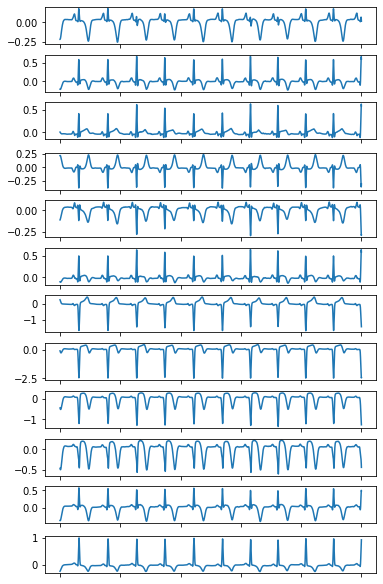

specgram.shape torch.Size([1, 12, 26, 201])
(312, 201)


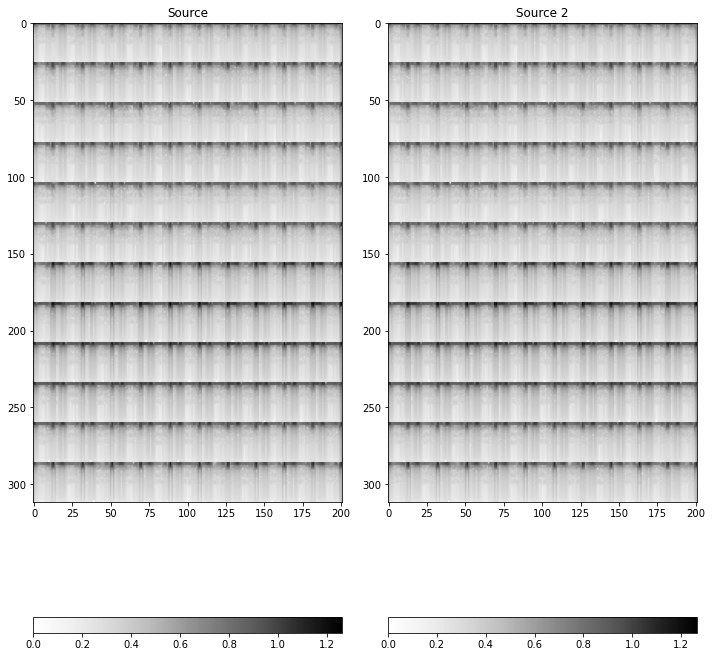

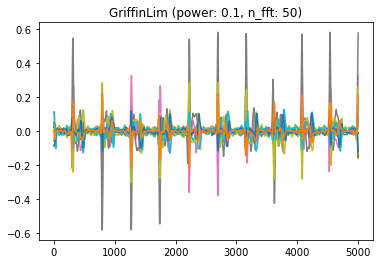

In [23]:
print(p_signal.shape)

# fig, ax = plt.subplots(12, figsize=(5, 8), sharex=True)
# for i in range(12):
#     ax[i].plot(p_signal[0,:,i])
#     ax[i].set_ylabel(None)
# fig.tight_layout()
# plt.show()

sig_fig = plt.figure(constrained_layout=True, figsize=(10, 8))
spec = gridspec.GridSpec(ncols=2, nrows=12, figure=sig_fig)
ax = None
for i in range(12):
    ax = sig_fig.add_subplot(spec[i, 0], sharex=ax)
    ax.set_xticklabels([])
    ax.plot(p_signal[0,:,i])
#     ax[i].set_ylabel(None)
spec.tight_layout(sig_fig)
plt.show()

n_fft = 50

# power
power = 0.1

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    n = torchaudio.transforms.Spectrogram(
        n_fft = n_fft,
        power = power,
        normalized=True
    )
    specgram = n(torch.Tensor(torch.transpose(p_signal, 1, 2)))
    print("specgram.shape", specgram.shape)
    rn = torchaudio.transforms.GriffinLim(n_fft = n_fft, power = power)
    recon = rn(specgram)


# fig, axs = plt.subplots(12, 1, figsize=(10, 26))
# # plt.imshow(specgram[0,:,:].log2().numpy())
# for i in range(12):
#     axs[i].set_title(f"Lead {i} (power: {power}, n_fft: {n_fft})")
#     pcm = axs[i].imshow(specgram[0,i,:,:].numpy())
#     fig.colorbar(pcm, orientation="horizontal", ax=axs[i])
#     print(i, scipy.stats.describe(specgram[0,i,:,:].numpy().flatten()))
# #     axs[i].colorbar()
# fig.tight_layout()
# plt.show()

specgram = specgram.detach().cpu().numpy()
specgram_img = np.concatenate([specgram[0, i, :, :].squeeze() for i in range(12)])
print(specgram_img.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 11))
ax[0].set_title("Source")
im = ax[0].imshow(specgram_img, cmap='Greys')
fig.colorbar(im, ax=ax[0], orientation="horizontal")
ax[1].set_title("Source 2")
im = ax[1].imshow(specgram_img, cmap='Greys')
fig.colorbar(im, ax=ax[1], orientation="horizontal")
fig.tight_layout()
plt.show()

# fig = plt.figure(figsize=(10, 20))
# plt.imshow(specgram_img)
# plt.show()

plt.figure()
plt.title(f"GriffinLim (power: {power}, n_fft: {n_fft})")
plt.plot(recon[0].T)
plt.show()

False
torch.Size([62712])
torch.Size([62712])


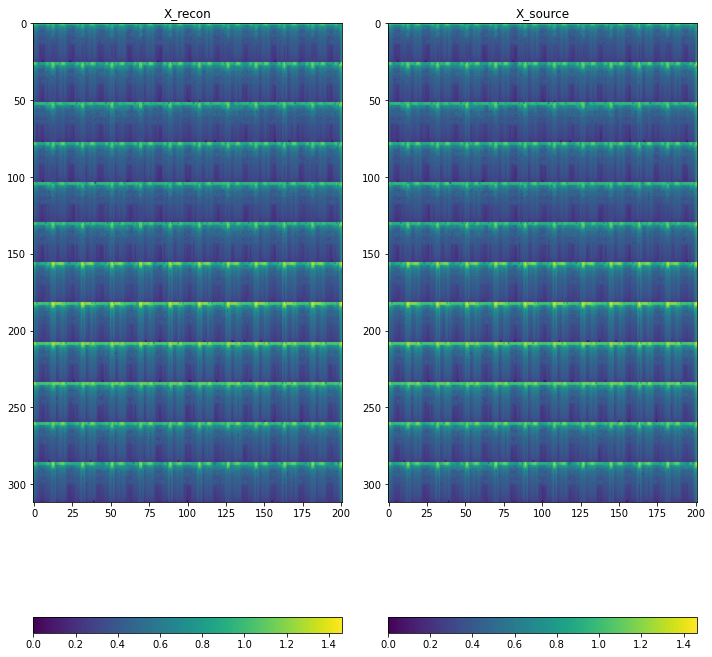

In [24]:
import torch.nn.functional as F

F.mse_loss(torch.Tensor([0.0, 0.0, 0.0]), torch.Tensor([0.3, 0.5, 0.6]))

n = torchaudio.transforms.Spectrogram(
    n_fft = 50,
    power = 0.1,
#     normalized=True
)
any(torch.isnan(n(torch.zeros(1, 12, 5000))).flatten())

# with open("nan_loss.npy", "rb") as f:
#     x_recon = torch.Tensor(np.load(f))
#     x_source = torch.Tensor(np.load(f))
x_source = n(torch.transpose(p_signal, 1, 2))
x_recon = n(torch.transpose(p_signal, 1, 2))

print(any(torch.isnan(x_source).flatten()))

# print(x_recon)
print(x_source[~torch.isnan(x_source)].shape)
print(x_recon[~torch.isnan(x_source)].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 11))
ax[0].set_title("X_recon")
spec_recon = np.concatenate([x_recon[0, i, :, :].squeeze() for i in range(12)])
im = ax[0].imshow(spec_recon)
fig.colorbar(im, ax=ax[0], orientation="horizontal")
ax[1].set_title("X_source")
spec_source = np.concatenate([x_source[0, i, :, :].squeeze() for i in range(12)])
im = ax[1].imshow(spec_source)
fig.colorbar(im, ax=ax[1], orientation="horizontal")
fig.tight_layout()
plt.show()


## TorchAudio SPEECHCOMMANDS Dataset

In [28]:
ds = torchaudio.datasets.SPEECHCOMMANDS("data", download=True)

100.0%


In [29]:
len(ds)

105829

In [30]:
waveform, sample_rate, utterance, speaker_id, utterance_id = ds[10]
waveform, sample_rate, utterance, speaker_id, utterance_id

(tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0518e-05, 0.0000e+00,
          0.0000e+00]]),
 16000,
 'yes',
 '6ef407da',
 1)

In [31]:
waveform.shape


torch.Size([1, 16000])

In [32]:
display(Audio(data=waveform, rate=sample_rate))

(129,) (71,) (129, 71)


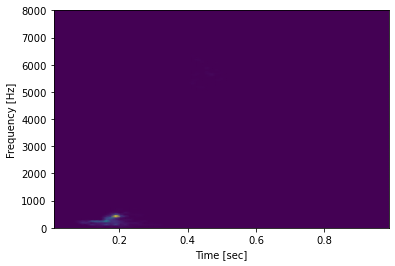

In [33]:
f, t, Sxx =signal.spectrogram(waveform.view(-1), fs=sample_rate)
print(f.shape, t.shape, Sxx.shape)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

torch.Size([1, 201, 81])


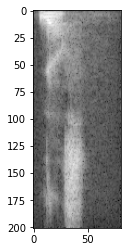

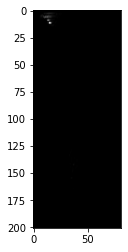

In [34]:
specgram = torchaudio.transforms.Spectrogram()(waveform)
plt.figure()
print(specgram.shape)
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap="gray")
plt.show()
plt.imshow(specgram[0,:,:].numpy(), cmap="gray")

### CinC2020 Beat Dataset Exploration

In [35]:
from functools import partial

import numpy as np
import scipy.signal as ss
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import neurokit2 as nk
from wfdb import rdrecord

from datasets.utils import walk_files, parse_comments


In [36]:
root = "data"
ecg_records = tuple(walk_files(root, suffix=".hea", prefix=True, remove_suffix=True))


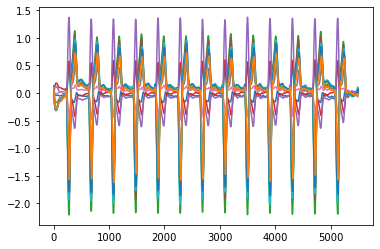

/home/alexwong/miniconda3/envs/msc_research/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


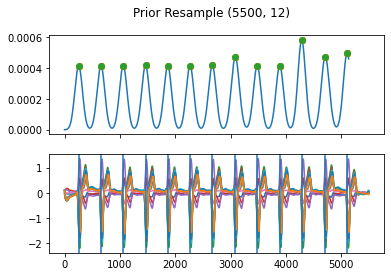

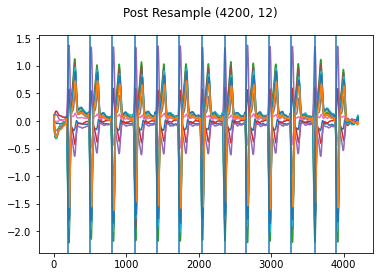

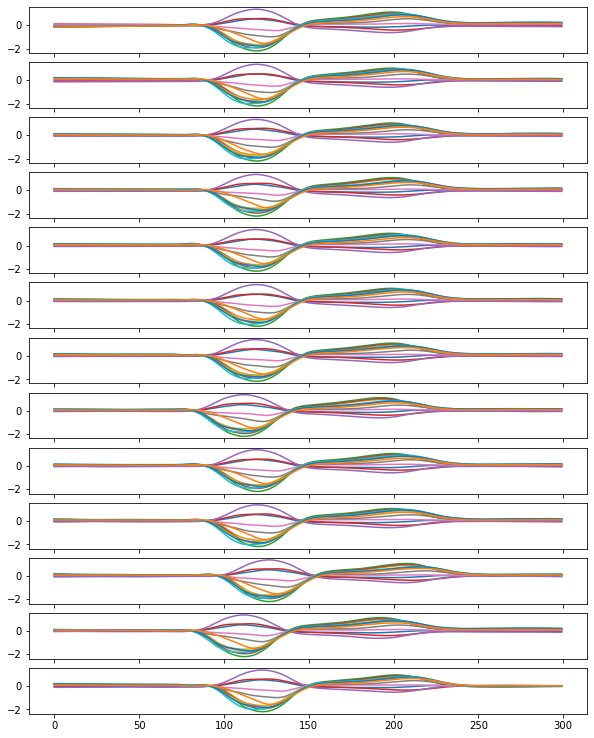

(13, 300, 12)


43099

In [38]:
def clean_ecg_nk2(ecg_signal, sampling_rate=500):
    """
    Parallelized version of neurokit2 ecg_clean(method="neurokit")
    ecg_signal shape should be (signal_length, number of leads)
    """
    # Remove slow drift with highpass Butterworth.
    sos = ss.butter(
        5,
        (0.5,),
        btype="highpass",
        output="sos",
        fs=sampling_rate,
    )
    clean = ss.sosfiltfilt(sos, ecg_signal, axis=0).T

    # DC offset removal with 50hz powerline filter (convolve average kernel)
    if sampling_rate >= 100:
        b = np.ones(int(sampling_rate / 50))
    else:
        b = np.ones(2)
    a = [
        len(b),
    ]
    clean = np.copy(ss.filtfilt(b, a, clean, method="pad", axis=1).T)

    return clean


def derive_rpeak_samples(ecg_record:str, pqrst_window_size: int = 300):
    """
    return window{0.35:0.65} window ranges around r-peak.
    resampled s.t. r-peak distance mean == window
    """
    record = rdrecord(ecg_record)
    age, sex, dx = parse_comments(record.comments)
    
    p_signal = record.p_signal
    sampling_rate = record.fs
    
    # clean the signal
    p_signal = clean_ecg_nk2(p_signal, sampling_rate)
   
    plt.plot(p_signal)
    plt.show()

    def nk_ecg_peaks(cleaned_signal):
        try:
            return nk.ecg_peaks(
                cleaned_signal,
                sampling_rate=sampling_rate,
                method="neurokit",
                correct_artifacts=True
            )
        except Exception:
            return None, {"ECG_R_Peaks": []}
        
    # determine the locations of each R-peak in all of the leads
    r_peaks_df, r_peak_dicts = zip(*map(nk_ecg_peaks, p_signal.T))
    # print(len(r_peak_dicts), r_peak_dicts)
    # join all of these locations into a single vector
    r_peaks = np.concatenate([
        r_peak_dict["ECG_R_Peaks"] for r_peak_dict in r_peak_dicts
    ])[:, np.newaxis]
    if len(r_peaks) == 0:
        raise Exception(f"{ecg_record}, No R-peaks detected in signal!")
    sig_range = np.linspace(0, r_peaks.max(), len(p_signal))[:, np.newaxis]

    # Find the peaks with bandwidth according to rough mean RR
    rough_meanrr = np.mean([
        np.diff(r_peak_dict["ECG_R_Peaks"]).mean()
        for r_peak_dict in r_peak_dicts
        if len(r_peak_dict["ECG_R_Peaks"]) >= 2
    ])
    # print(rough_meanrr)
    kde = KernelDensity(bandwidth=rough_meanrr/10).fit(r_peaks)
    log_dens = kde.score_samples(sig_range)
    dens = np.exp(log_dens)
    peaks, _ = ss.find_peaks(dens)

    # keep only the peaks that are greater than the mean density -  1std
    threshold_peak_density = dens[peaks].mean() - dens[peaks].std()
    valid_peaks = peaks[dens[peaks] > threshold_peak_density]

    # DISPLAY/DEBUGGING PURPOSES
    fig, axs = plt.subplots(2, sharex=True)
    axs[0].plot(sig_range[:, 0], dens)
    axs[0].plot(sig_range[peaks], dens[peaks], "X")
    axs[0].plot(sig_range[valid_peaks], dens[valid_peaks], "o")
    axs[1].plot(p_signal)
    fig.suptitle(f"Prior Resample {p_signal.shape}")
    for vpeak in sig_range[valid_peaks]:
        plt.axvline(x=vpeak)
    plt.show()

    # resample the signal such that the mean distance between 
    # valid R-peaks is equal to `pqrst_window_size`
    scaling_indicies = sig_range[valid_peaks].squeeze()
    scaling_indicies = np.insert(scaling_indicies, 0, 0)
    scaling_indicies = np.append(scaling_indicies, len(p_signal))
    peak_diff_dist = np.diff(scaling_indicies)
    mean_peak_diff_dist = peak_diff_dist.mean()
    resamp_to_len = (len(p_signal) / mean_peak_diff_dist) * pqrst_window_size
    resamp_to_len = int(np.ceil(resamp_to_len))
    p_signal = ss.resample(p_signal, resamp_to_len)
    # resample the peaks so we don't have to calculate again
    scaling_factor = pqrst_window_size / mean_peak_diff_dist
    upscaled_peak_diff_dist = peak_diff_dist * scaling_factor
    scaled_indicies = np.r_[scaling_indicies[0], upscaled_peak_diff_dist].cumsum()
    scaled_indicies = scaled_indicies[1:-1]

    # DISPLAY/DEBUGGING PURPOSES
    fig, axs = plt.subplots(1, sharex=True)
    axs.plot(p_signal)
    fig.suptitle(f"Post Resample {p_signal.shape}")
    for sc in scaled_indicies:
        plt.axvline(x=sc)
    plt.show()

    # slice up windows and return new matrices
    valid_windows = []
    sc_loffset = pqrst_window_size * 0.35
    for sc in scaled_indicies:
        left_offset = int(np.floor(sc-sc_loffset))
        scaled_window = p_signal[left_offset:left_offset + pqrst_window_size]
        if len(scaled_window) != pqrst_window_size:
            # ignore windows that don't fit into window size
            continue
        valid_windows.append(scaled_window)
        
    fig, axs = plt.subplots(len(valid_windows), sharex=True, figsize=(10, len(valid_windows)))
    for i in range(len(valid_windows)):
        axs[i].plot(valid_windows[i])
    plt.show()
    
    print(np.stack(valid_windows).shape)

# derive_rpeak_samples(ecg_records[7]) # 7 is ugly
# derive_rpeak_samples(ecg_records[11])  # lots of peaks
derive_rpeak_samples("data/Training_2/Q0138") # no rpeaks?
# derive_rpeak_samples("data/Training_2/Q0400") # no identity?
# derive_rpeak_samples("data/Training_2/Q2961") # no identity?
len(ecg_records)


In [39]:
from datasets import CinC2020Beats

In [48]:
ds = CinC2020Beats()
dl = DataLoader(ds, batch_size=3, shuffle=True)

In [49]:
windows, age, sex, dx = next(iter(dl))
windows.shape

torch.Size([3, 400, 12])